In [1]:
from IPython import get_ipython


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import IPython
get_ipython().run_line_magic('matplotlib', 'notebook')
#pd.options.display.max_rows = None
#pd.options.display.max_columns = None



In [21]:
NUM_MELHORES = 60



In [4]:
CO_SAO_BENTO = 33062633
CO_SAO_VICENTE = 33063648
CO_PARQUE = 33065837
CO_ELEVA = 33178860

CO_MUN_RIO = 3304557
CO_UF_RIO = 33



In [5]:
#df_turmas = pd.read_feather('dados/turmas2018.feather')
df_escolas = pd.read_feather('dados/escolas_rio_2018.feather')
df_primeiro_ano_turmas = pd.read_feather('dados/primeiro_ano.feather')



In [6]:
df_enem_rio = pd.read_feather('dados/enem_rio_2018.feather')


 ## Nota final
 Abaixo pode-se personalizar o cálculo de nota final. pondero pelas notas mais importantes.

 O Inep costuma considerar a redação como tendo um peso igual às outras disciplinas.

 Algumas universidades consideram um peso distinto de acordo com a disciplina

 ### Pesos UFRJ

 Referência dos [pesos da UFRJ](https://oglobo.globo.com/sociedade/educacao/ufrj-usara-pesos-diferentes-em-provas-do-enem-2011-para-acesso-aos-cursos-de-graduacao-2865665).

 - Redação: peso 3 (mínimo 300)
 - Ciência da Computação, Ciências Atuariais, Engenharias, Estatística, Matemática e Química Industrial
     - Matemática tem peso 4
 - Ciências Econômicas, Geologia e Meteorologia
     - Matemática peso 3
 - Engenharias e Química Industrial
     - Ciências da Natureza: peso 4
 - Geologia
     - Ciências da Natureza: peso 3
 - Humanas
     - Ciências Humanas e Linguagens: peso 2



In [7]:
notas_cols = ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO', ]
notas_pesos =(1, 1, 1, 1, 4)



In [8]:
media_ponderada = lambda notas: np.average(notas, weights=notas_pesos)

df_enem_rio['nota_final'] = df_enem_rio  .loc[df_enem_rio.TP_ST_CONCLUSAO == 2, notas_cols ]  .apply(media_ponderada, axis=1).round(0)
df_enem_rio[notas_cols+ ['nota_final']].head()



,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO,nota_final
0,468.7,563.8,508.3,513.7,340.0,427.0
1,592.8,706.0,633.1,740.3,820.0,744.0
2,529.6,683.3,652.5,740.3,960.0,806.0
3,483.7,602.4,558.1,453.7,600.0,562.0
4,431.7,560.9,479.7,557.0,560.0,534.0


In [9]:
notas_agg = {col: (col, 'median') for col in notas_cols}
notas_agg['mediana'] = ('nota_final', 'median')
notas_agg['num'] = ('nota_final', 'count')

df_melhores = df_enem_rio.groupby('CO_ESCOLA')       .agg(**notas_agg).sort_values('mediana', ascending=False)
df_melhores = df_melhores[df_melhores.num > 30] #corte arbitrário, só quem tem mais de 30 alunos
df_melhores.head()



,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO,mediana,num
CO_ESCOLA,,,,,,,
33057206,646.5,693.00,649.4,768.6,940.0,807.0,83
33135371,662.7,691.40,635.0,763.2,920.0,803.0,91
33062633,689.5,702.85,645.7,801.1,900.0,800.5,62
33165920,645.9,697.60,638.3,768.7,920.0,798.0,51
33055866,668.4,678.50,630.5,755.6,920.0,798.0,31


In [10]:
df_melhores['CO_ESCOLA'] = df_melhores.index.astype('category')
df_melhores['rank'] = df_melhores.mediana.rank(ascending=False, method='min')



In [11]:
df_melhores = df_melhores.merge(df_escolas, left_index=True, right_on='CO_ENTIDADE').loc[:,
    ['NO_ENTIDADE',  'mediana', 'num', 'rank'] + notas_cols + ['CO_ENTIDADE']]
df_melhores



,NO_ENTIDADE,mediana,num,rank,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO,CO_ENTIDADE
177824,INSTITUTO GAYLUSSAC - ENS FUNDAMENTAL E MEDIO,807.0,83,1.0,646.50,693.00,649.40,768.60,940.0,33057206
189289,COLEGIO CRUZEIRO - JACAREPAGUA,803.0,91,2.0,662.70,691.40,635.00,763.20,920.0,33135371
177267,COL DE SAO BENTO,800.5,62,3.0,689.50,702.85,645.70,801.10,900.0,33062633
193270,COLEGIO E CURSO PENSI,798.0,51,4.0,645.90,697.60,638.30,768.70,920.0,33165920
176775,COL MARILIA MATTOSO,798.0,31,4.0,668.40,678.50,630.50,755.60,920.0,33055866
...,...,...,...,...,...,...,...,...,...,...
177195,CIEP 375 WILSON GREY,430.0,46,795.0,445.05,509.00,469.60,488.55,360.0,33046565
174380,CIEP 999 DOM PEDRO DALCANTARA DE BRAGANCA PRIM...,429.0,31,797.0,461.30,543.45,504.90,476.00,390.0,33037515
195642,UNIDADE ESCOLAR DA FUNDACAO ROBERTO MARINHO,427.0,83,798.0,451.05,532.80,481.95,467.35,360.0,33158746
189874,CIEP 331 LYSIA BERNARDES,427.0,39,798.0,456.80,533.20,486.65,494.50,360.0,33093709


In [12]:

df_enem = df_melhores[['CO_ENTIDADE']].merge(df_enem_rio, 
                     left_on='CO_ENTIDADE', right_on='CO_ESCOLA')\
          .loc[:,list(notas_cols) + ['CO_ESCOLA', 'nota_final']]
df_enem.head()



,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO,CO_ESCOLA,nota_final
0,671.1,688.5,647.8,781.3,900.0,33057206,799.0
1,560.1,626.7,630.1,735.2,960.0,33057206,799.0
2,521.1,687.0,630.2,698.3,860.0,33057206,747.0
3,558.1,722.0,691.8,701.3,940.0,33057206,804.0
4,585.9,667.1,641.0,725.6,820.0,33057206,737.0


In [13]:
my_order = df_melhores.head(NUM_MELHORES).NO_ENTIDADE


 Ajustar no gráfico abaixo:

 - diminuir nomes de escola muito grandes


In [14]:
df_melhores['rotulo'] = df_melhores.loc[:,['NO_ENTIDADE', 'num', 'rank']].apply(lambda x: '{:>s} {:03d}/{:>2.0f}'.format(x[0].title(), x[1], x[2]), axis=1)



In [15]:
df_melhores



,NO_ENTIDADE,mediana,num,rank,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO,CO_ENTIDADE,rotulo
177824,INSTITUTO GAYLUSSAC - ENS FUNDAMENTAL E MEDIO,807.0,83,1.0,646.50,693.00,649.40,768.60,940.0,33057206,Instituto Gaylussac - Ens Fundamental E Medio ...
189289,COLEGIO CRUZEIRO - JACAREPAGUA,803.0,91,2.0,662.70,691.40,635.00,763.20,920.0,33135371,Colegio Cruzeiro - Jacarepagua 091/ 2
177267,COL DE SAO BENTO,800.5,62,3.0,689.50,702.85,645.70,801.10,900.0,33062633,Col De Sao Bento 062/ 3
193270,COLEGIO E CURSO PENSI,798.0,51,4.0,645.90,697.60,638.30,768.70,920.0,33165920,Colegio E Curso Pensi 051/ 4
176775,COL MARILIA MATTOSO,798.0,31,4.0,668.40,678.50,630.50,755.60,920.0,33055866,Col Marilia Mattoso 031/ 4
...,...,...,...,...,...,...,...,...,...,...,...
177195,CIEP 375 WILSON GREY,430.0,46,795.0,445.05,509.00,469.60,488.55,360.0,33046565,Ciep 375 Wilson Grey 046/795
174380,CIEP 999 DOM PEDRO DALCANTARA DE BRAGANCA PRIM...,429.0,31,797.0,461.30,543.45,504.90,476.00,390.0,33037515,Ciep 999 Dom Pedro Dalcantara De Braganca Prim...
195642,UNIDADE ESCOLAR DA FUNDACAO ROBERTO MARINHO,427.0,83,798.0,451.05,532.80,481.95,467.35,360.0,33158746,Unidade Escolar Da Fundacao Roberto Marinho 08...
189874,CIEP 331 LYSIA BERNARDES,427.0,39,798.0,456.80,533.20,486.65,494.50,360.0,33093709,Ciep 331 Lysia Bernardes 039/798


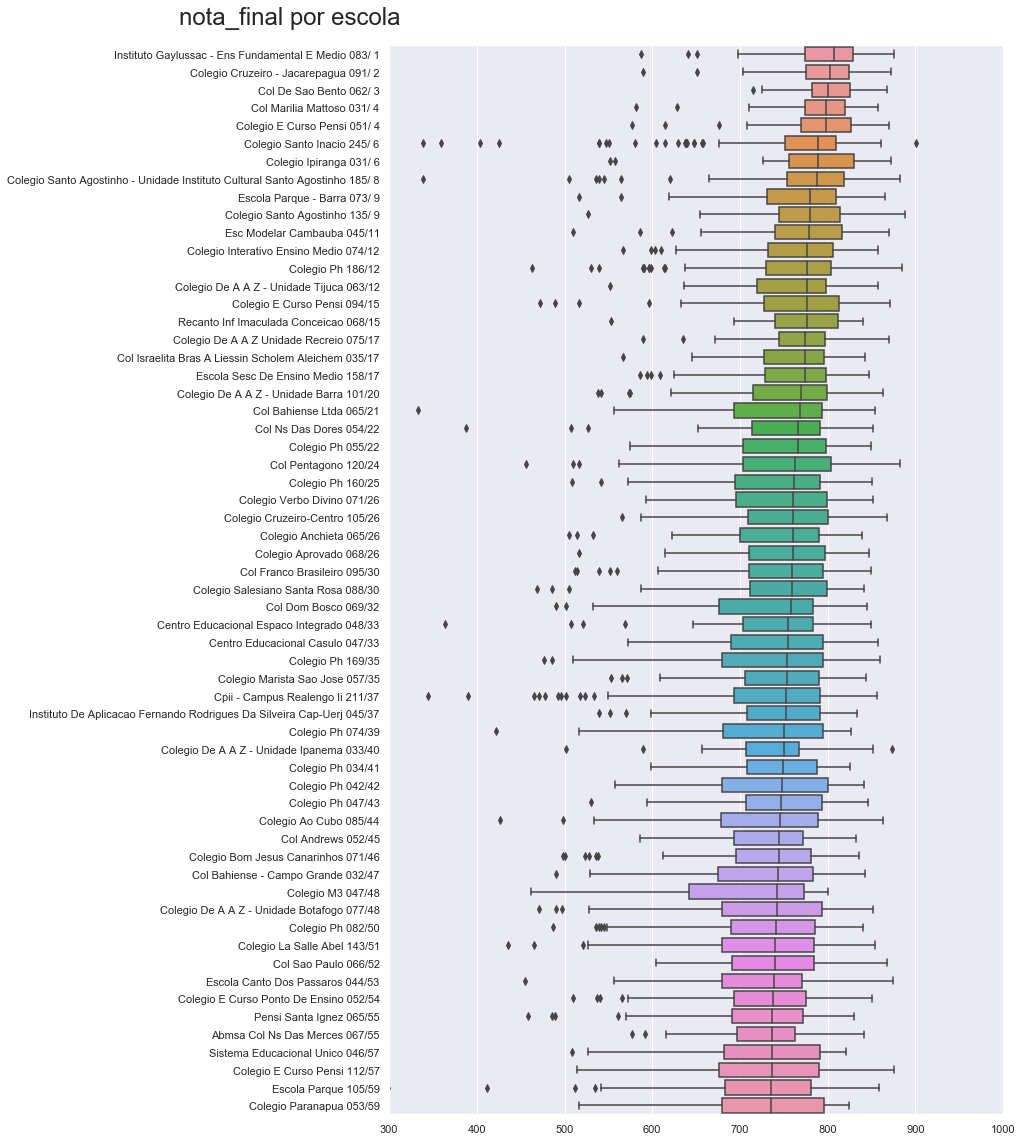

In [22]:


def compara_distribuicoes(nota):
    sns.set(rc={'figure.figsize':(11,18), 'axes.xmargin': .1})
    #sns.palplot(sns.hls_palette(8, l=.3, s=.8))
    
    nota_agrupada = nota
    if nota=='nota_final':
        nota_agrupada = 'mediana'
    
    df_top = df_melhores.sort_values(nota_agrupada, ascending=False).head(NUM_MELHORES)
    ax = sns.boxplot(data=df_enem, y='CO_ESCOLA', x=nota, orient='h'
                     ,order=df_top.CO_ENTIDADE)
    ax.set(ylabel='', xlabel='')
    plt.gcf().subplots_adjust(top=.95)
    plt.suptitle(f'{nota} por escola',x=0, size=24, );
    locs, _ = plt.yticks()
    plt.yticks(locs, df_top.rotulo);
    ax.set_xlim(300, 1000)
    

compara_distribuicoes('nota_final');



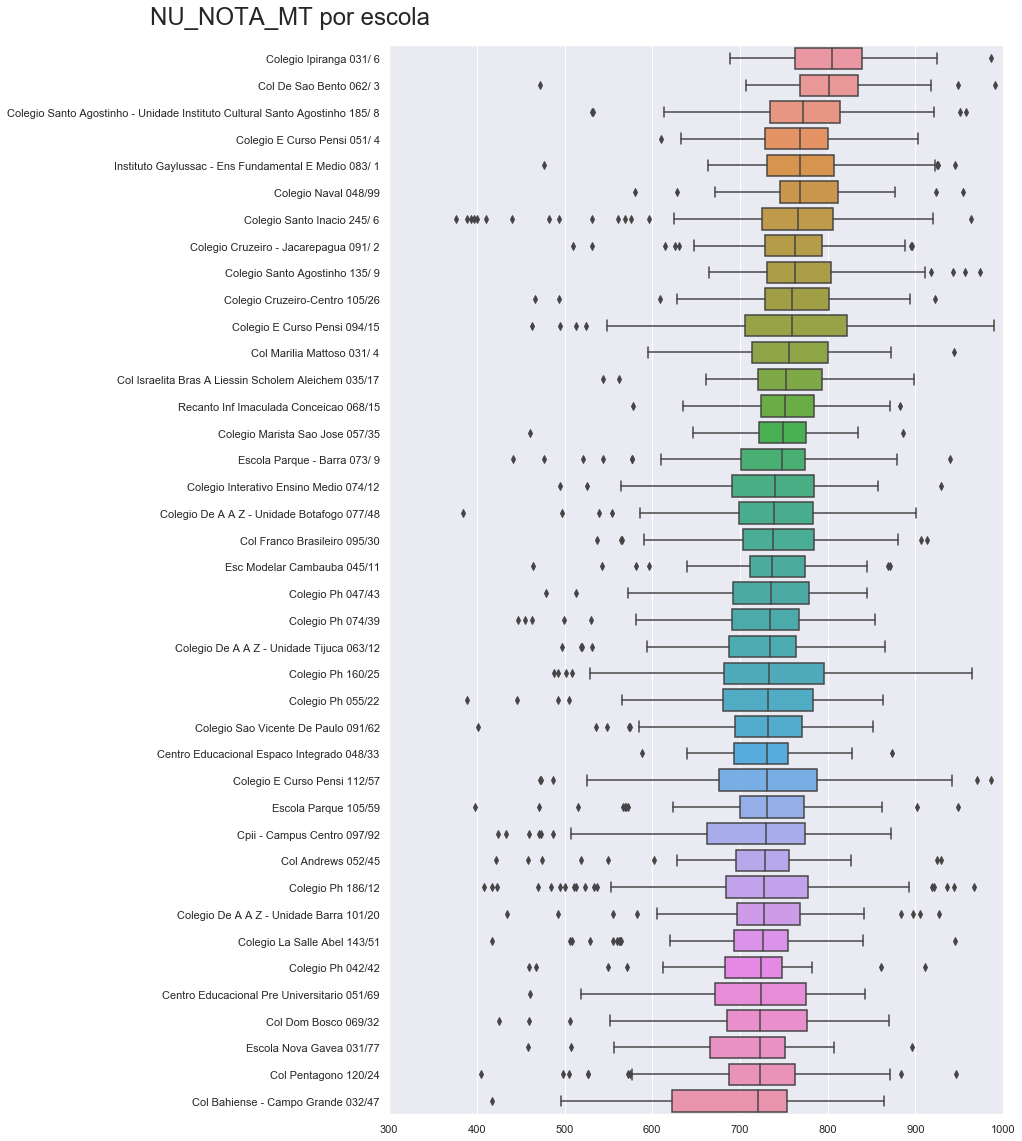

In [17]:
compara_distribuicoes('NU_NOTA_MT');



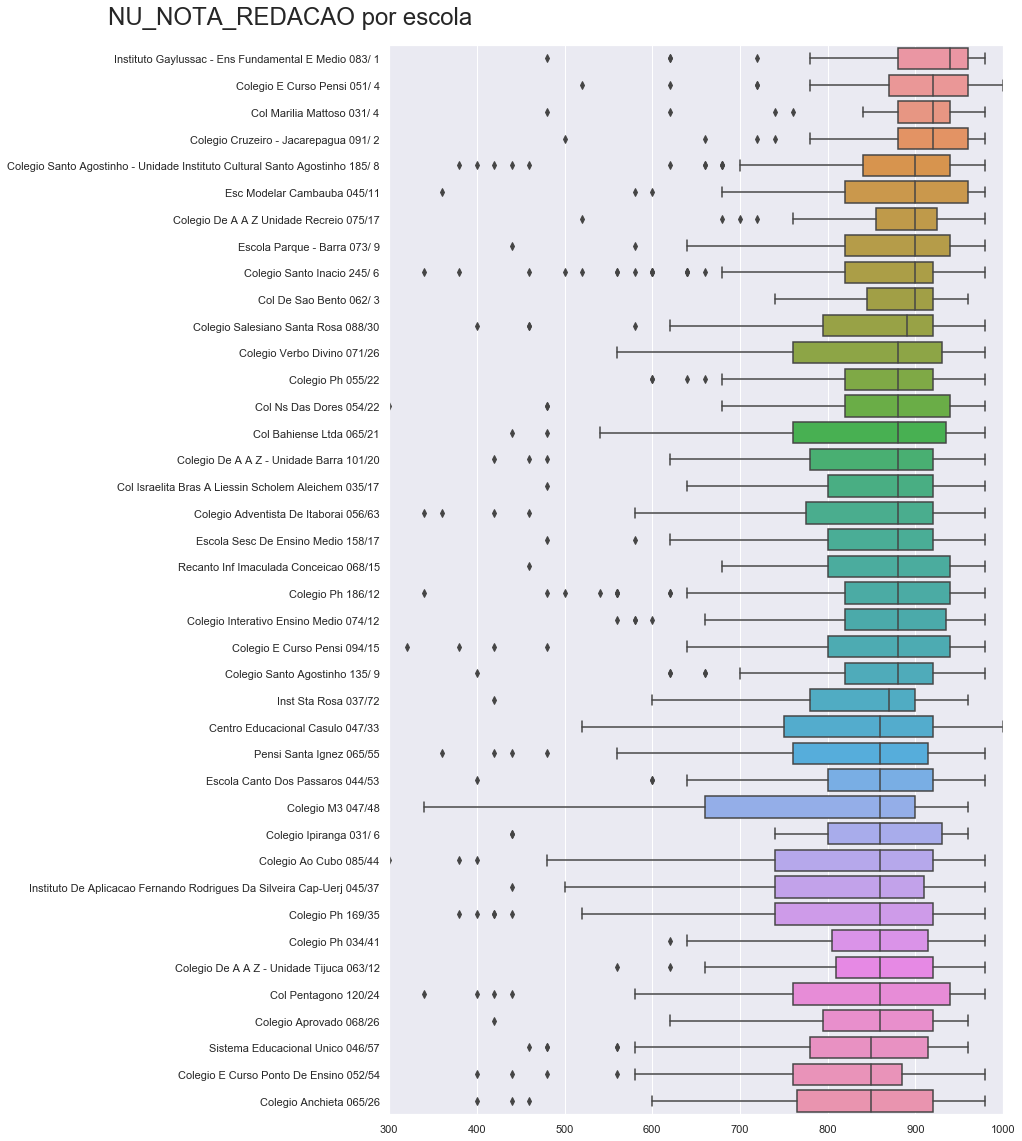

In [18]:
compara_distribuicoes('NU_NOTA_REDACAO');



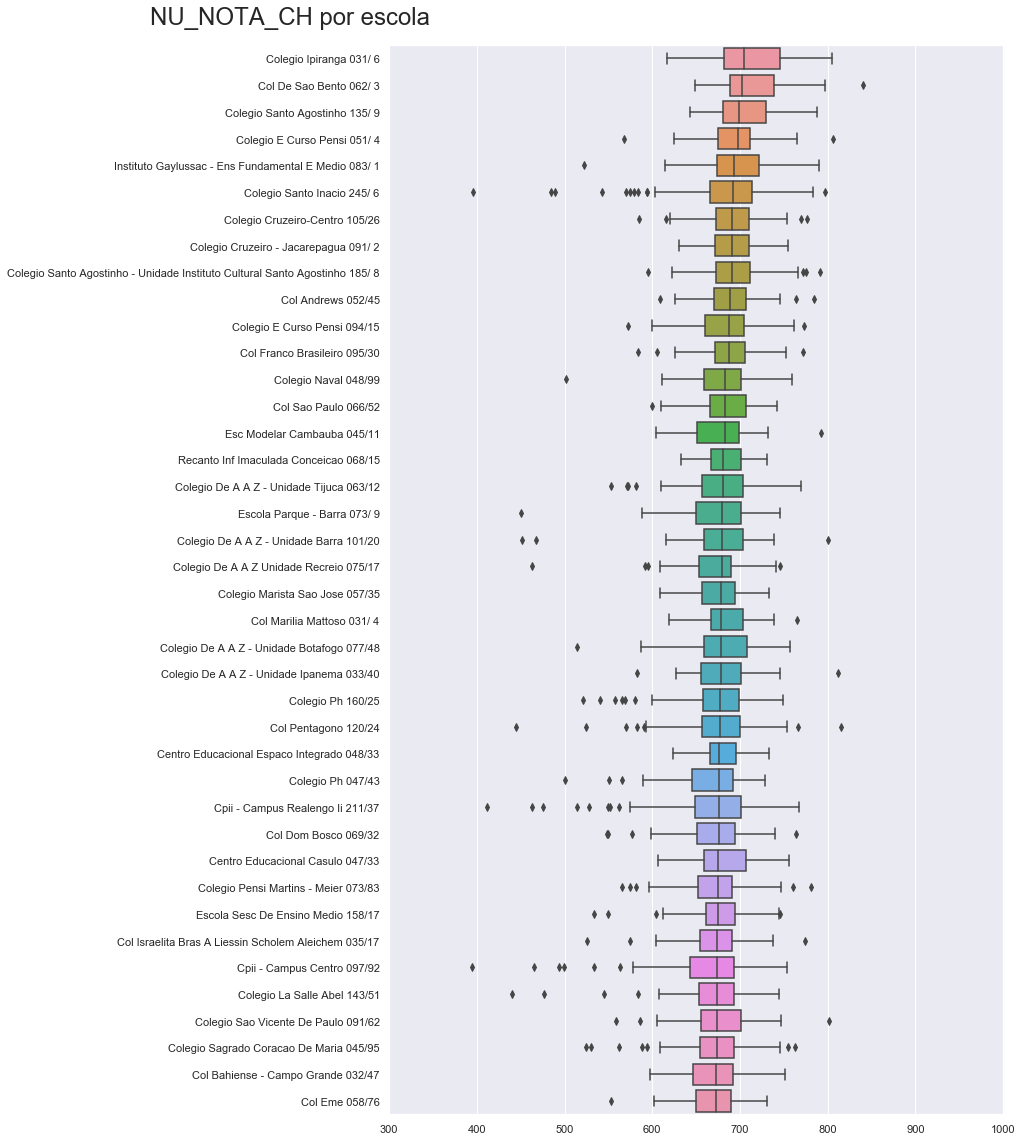

In [19]:
compara_distribuicoes('NU_NOTA_CH');


 ## Sobrevivência no ensino médio

 Quantos dos alunos que começam o ensino médio fazem Enem?

 Motivos para diminuir:
 - Maus alunos são expulsos
 - Maus alunos não acreditam que passarão no Enem
 - Vai para universidade fora do Enem (ITAs, PUCs, USP, exterior etc.)

 Motivos para aumentar:
 - Crise econômica (escolas públicas)
 - Bolsa para bons alunos

 ### ideias
 - comparar com último ano (dá ideia melhor da seleção feita pela escola)
 - comparar com quem fez prova (ideia melhor de auto seleção)

In [24]:
etapa_col = 'TP_ETAPA_ENSINO'
primeiro_ano = [25,  30, 35]
# todo: tratar ensinos médios de 4 anos
df_primeiro_ano_turmas = pd.read_feather('dados/primeiro_ano.feather')




In [25]:
df_ano_um = df_primeiro_ano_turmas.groupby(['id_escola', 'ano'])['num_matriculas'].sum()
CO_ELEVA=33178860
df_ano_um.unstack().T



id_escola,33000026,33000042,33000069,33000077,33000115,33000158,33000212,33000220,33000360,33000662,...,33541221,33547211,33548234,33548242,33548250,33551219,33552223,33552231,33558221,33558230
ano,,,,,,,,,,,,,,,,,,,,,
2007,90.0,216.0,26.0,108.0,NaN,121.0,21.0,19.0,101.0,17.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008,73.0,194.0,25.0,102.0,NaN,105.0,24.0,19.0,113.0,34.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009,51.0,177.0,2.0,149.0,NaN,143.0,NaN,20.0,111.0,42.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010,36.0,111.0,NaN,194.0,23.0,153.0,20.0,23.0,108.0,36.0,...,10.0,87.0,70.0,85.0,43.0,41.0,NaN,13.0,NaN,NaN
2011,55.0,128.0,NaN,207.0,6.0,154.0,7.0,21.0,105.0,32.0,...,8.0,93.0,68.0,73.0,30.0,48.0,11.0,15.0,12.0,587.0
2012,63.0,138.0,NaN,210.0,15.0,127.0,11.0,15.0,95.0,22.0,...,25.0,101.0,71.0,88.0,46.0,46.0,NaN,20.0,18.0,593.0
2013,54.0,104.0,NaN,228.0,7.0,143.0,NaN,15.0,171.0,18.0,...,18.0,87.0,76.0,133.0,48.0,NaN,4.0,29.0,36.0,687.0
2014,51.0,99.0,NaN,230.0,12.0,153.0,NaN,12.0,165.0,21.0,...,8.0,108.0,72.0,88.0,22.0,NaN,7.0,20.0,47.0,635.0
2015,56.0,98.0,NaN,262.0,9.0,142.0,NaN,NaN,159.0,25.0,...,13.0,106.0,70.0,96.0,16.0,NaN,5.0,33.0,53.0,610.0


In [28]:
with pd.option_context('display.max_columns', None):
    display(df_primeiro_ano_turmas.loc[df_primeiro_ano_turmas.id_escola == CO_SAO_VICENTE])



,index,ano,id_escola,id_etapa,id_municipio,id_uf,num_matriculas
3437,358067,2007,33063648,25.0,3304557,33,34
3438,358070,2007,33063648,25.0,3304557,33,32
3440,358240,2007,33063648,25.0,3304557,33,34
3449,360679,2007,33063648,25.0,3304557,33,34
12640,1452126,2008,33063648,25.0,3304557,33,35
12641,1452128,2008,33063648,25.0,3304557,33,35
12642,1452130,2008,33063648,25.0,3304557,33,36
12643,1452139,2008,33063648,25.0,3304557,33,37
19866,1482910,2009,33063648,25.0,3304557,33,33
19867,1482911,2009,33063648,25.0,3304557,33,35


In [ ]:
df_ano_um = pd.concat([df_melhores.set_index('CO_ENTIDADE')[['rotulo', 'num', 'rank']], df_ano_um['NU_MATRICULAS']], axis=1)
df_ano_um.sort_values('rank').head(40)



In [ ]:
df_ano_um['%'] = df_ano_um.num/df_ano_um.NU_MATRICULAS



In [ ]:
df_ordered = df_ano_um.sort_values('rank').head(NUM_MELHORES).sort_values('%')
ax = df_ordered['%'].plot.bar()
loc, _ = plt.xticks()
plt.xticks(loc, df_ordered.rotulo);


